## Key Requirements for the iRF scikit-learn implementation

* The following is a documentation of the main requirements for the iRF implementation

## Typical Setup

In [1]:
# Setup
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
from sklearn import tree
import numpy as np

# Define a function to draw the decision trees in IPython
# Adapted from: http://scikit-learn.org/stable/modules/tree.html
from IPython.display import display, Image
import pydotplus

# Custom util functions
from utils import utils

RANDOM_SEED_SPLIT = 1001
RANDOM_SEED_SPLIT    = 1039

/Users/shamindras/anaconda/envs/sklearnprod0/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Step 1: Fit the Initial Random Forest

* Just fit every feature with equal weights per the usual random forest code e.g. DecisionForestClassifier in scikit-learn

In [2]:
# Load the iris data
iris = load_iris()

# Create the train-test datasets
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state = RANDOM_SEED_SPLIT)

# Just fit a simple random forest classifier with 2 decision trees
rf = RandomForestClassifier(n_estimators = 2, random_state = RANDOM_SEED_SPLIT)
rf.fit(X = X_train, y = y_train)

# Now plot the trees individually
#for idx, dtree in enumerate(rf.estimators_):
#    print(idx)
#    utils.draw_tree(inp_tree = dtree)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2, n_jobs=1, oob_score=False, random_state=1039,
            verbose=0, warm_start=False)

### Check that we can store objects of different types in a dictionary

* This includes storing the random forest object under one key and also a simple numerial value in another key

In [3]:
a = 1
test = {} # create the dictionary to store the objects
test['first']  = a
test['rf_obj'] = rf

In [4]:
print(test['first'])
print(test['rf_obj'].feature_importances_)

1
[ 0.04399508  0.00327378  0.26606965  0.68666149]


**Yay - seems to work just fine!**

## Step 2: Get the Gini Importance of Weights

* For the first random forest we just need to get the Gini Importance of Weights

### Step 2.1 Get them numerically - most important

In [5]:
importances = rf.feature_importances_
std = np.std([dtree.feature_importances_ for dtree in rf.estimators_]
             , axis=0)
indices = np.argsort(importances)[::-1]

# Check that the feature importances are standardized to 1
print(sum(importances))

1.0


### Step 2.2 Display Feature Importances Graphically (just for interest)

Feature ranking:
1. feature 3 (0.686661)
2. feature 2 (0.266070)
3. feature 0 (0.043995)
4. feature 1 (0.003274)


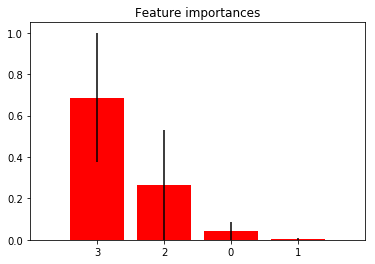

In [6]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Step 3: For each Tree get core leaf node features

* For each decision tree in the classifier, get:
    * The list of leaf nodes
    * Depth of the leaf node    
    * Leaf node predicted class i.e. {0, 1}
    * Probability of predicting class in leaf node
    * Number of observations in the leaf node i.e. weight of node

### Name the Features

In [7]:
feature_names = ["X" + str(i) for i in range(X_train.shape[1])]
target_vals = list(np.sort(np.unique(y_train)))
target_names = ["y" + str(i) for i in target_vals]
print(feature_names)
print(target_names)

['X0', 'X1', 'X2', 'X3']
['y0', 'y1', 'y2']


### Get the second Decision tree to use for testing

In [8]:
estimator = rf.estimators_[1]

In [9]:
from sklearn.tree import _tree
estimator.tree_.children_left[0]
estimator.tree_.children_right[0]

6

### Write down an efficient Binary Tree Traversal Function

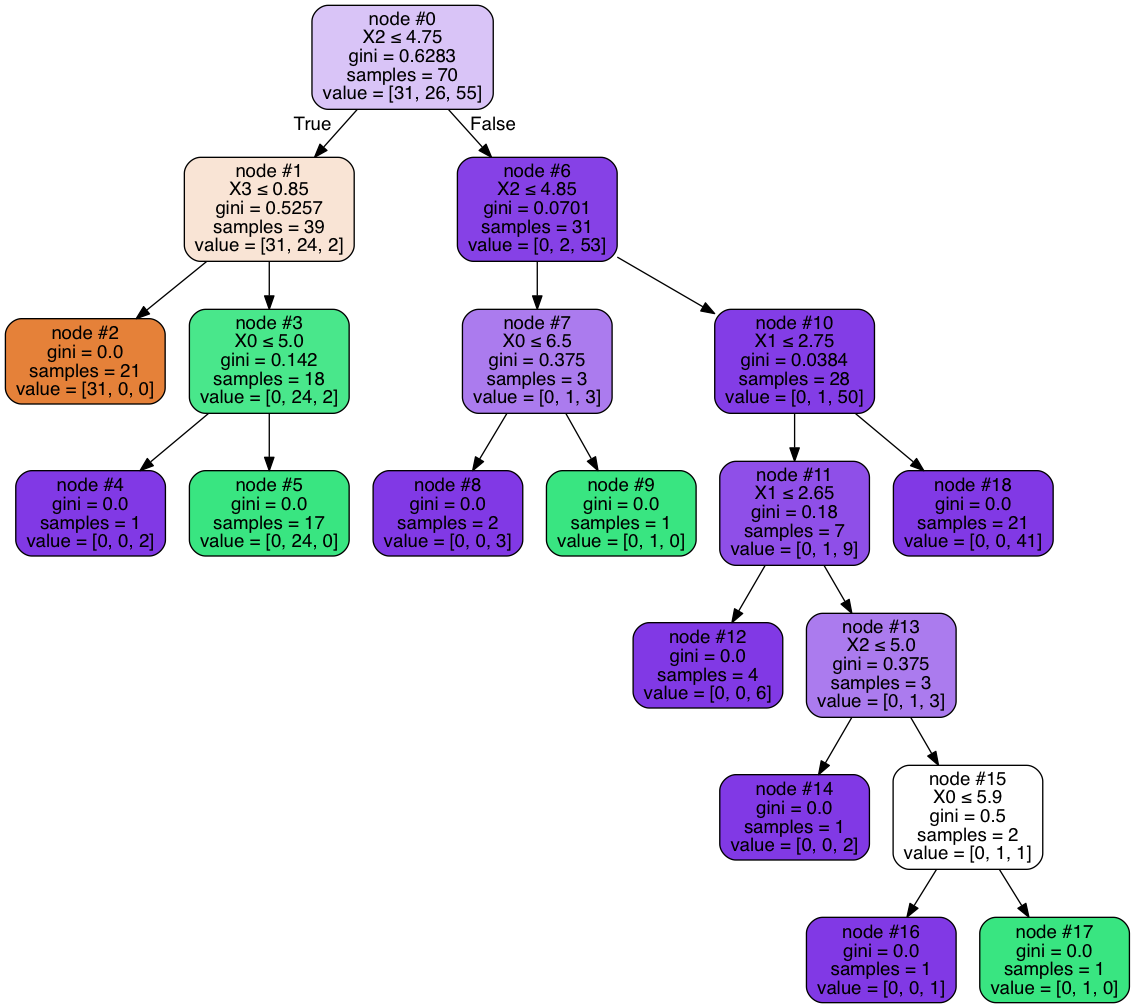

In [10]:
# Now plot the trees individually
utils.draw_tree(inp_tree = estimator)

### Create the single function to output the required values

We have the following **inputs**:
* Decision Tree Classifier from the Random Forest Classifier
* Root node id = 0 (should be the default and only value passed in here)

We have the following **outputs**:
* Leaf node paths in order
* Max node depth
* Leaf node predicted class {0, 1}
* Total leaf node samples
* Leaf node class sample sizes
* Leaf node class sample proportions
* Unordered boolean features

In [11]:
# Setup the key variables
threshold       = estimator.tree_.threshold

In [12]:
max_node_depth = estimator.tree_.max_depth
max_node_depth
print("Max node depth in tree", max_node_depth, sep = ":\n")

Max node depth in tree:
6


In [13]:
n_nodes         = estimator.tree_.node_count
print("number of nodes in tree", n_nodes, sep = ":\n")

number of nodes in tree:
19


In [14]:
# Define the number of features
num_features = X_train.shape[1]

# Get the node features from the decision tree classifier attribute
# It is hard to tell which features this came from i.e. indices are zero,
# positive and negative - we want only non-negative indices for the 
# corresponding feature columns
node_features   = estimator.tree_.feature

node_features_idx = np.array(range(num_features))[node_features]

# Count the unique number of features used
_ , num_features_used = np.unique(node_features_idx, return_counts=True)

print("number of node features", len(num_features_used), sep = ":\n")
print("node features", node_features, sep = ":\n")
print("node feature indices", node_features_idx, sep = ":\n")

number of node features:
4
node features:
[ 2  3 -2  0 -2 -2  2  0 -2 -2  1  1 -2  2 -2  0 -2 -2 -2]
node feature indices:
[2 3 2 0 2 2 2 0 2 2 1 1 2 2 2 0 2 2 2]


In [17]:
def allTreePaths(dtree, root_node_id = 0):

    # Use these lists to parse the tree structure
    children_left  = dtree.tree_.children_left
    children_right = dtree.tree_.children_right

    if root_node_id is None: 
        paths      = []
    
    if root_node_id == _tree.TREE_LEAF:
        raise ValueError("Invalid node_id %s" % _tree.TREE_LEAF)
        
    # if left/right is None we'll get empty list anyway
    if children_left[root_node_id] != _tree.TREE_LEAF:
        paths = [np.append(root_node_id, l)
                 for l in allTreePaths(dtree, children_left[root_node_id]) + 
                          allTreePaths(dtree, children_right[root_node_id])]

    else:
        paths = [root_node_id]
    
    return paths

In [20]:
all_leaf_node_paths = allTreePaths(rf.estimators_[1], root_node_id = 0)
all_leaf_node_paths

[array([0, 1, 2]),
 array([0, 1, 3, 4]),
 array([0, 1, 3, 5]),
 array([0, 6, 7, 8]),
 array([0, 6, 7, 9]),
 array([ 0,  6, 10, 11, 12]),
 array([ 0,  6, 10, 11, 13, 14]),
 array([ 0,  6, 10, 11, 13, 15, 16]),
 array([ 0,  6, 10, 11, 13, 15, 17]),
 array([ 0,  6, 10, 18])]

In [21]:
leaf_nodes = [path[-1] for path in all_leaf_node_paths]
leaf_nodes

[2, 4, 5, 8, 9, 12, 14, 16, 17, 18]

## Check that the following leaf node depth is correct 

* **CHECK: That depth is correct value and not added 1 by accident**
* Root node must have depth 0 so **need to deduct 1 from  from the length** of the path
* **CHECK: whether we can implement this directly in our getTreePaths function**

In [26]:
leaf_nodes_depths = [np.size(y) - 1 for y in all_leaf_node_paths]
leaf_nodes_depths

[2, 3, 3, 3, 3, 4, 5, 6, 6, 3]

In [27]:
n_node_samples = estimator.tree_.n_node_samples
num_samples = [n_node_samples[y].astype(int) for y in leaf_nodes]
print(n_node_samples)
print(len(n_node_samples))
num_samples
print(num_samples)
print(sum(num_samples))
print(sum(n_node_samples))

[70 39 21 18  1 17 31  3  2  1 28  7  4  3  1  2  1  1 21]
19
[21, 1, 17, 2, 1, 4, 1, 1, 1, 21]
70
271


In [28]:
X_train.shape

(112, 4)

In [30]:
value  = estimator.tree_.value
values = [value[node_id].astype(int) for node_id in leaf_nodes]
print(values)
# This should match the number of rows in the training feature set
print(sum(values).sum())
values

[array([[31,  0,  0]]), array([[0, 0, 2]]), array([[ 0, 24,  0]]), array([[0, 0, 3]]), array([[0, 1, 0]]), array([[0, 0, 6]]), array([[0, 0, 2]]), array([[0, 0, 1]]), array([[0, 1, 0]]), array([[ 0,  0, 41]])]
112


[array([[31,  0,  0]]),
 array([[0, 0, 2]]),
 array([[ 0, 24,  0]]),
 array([[0, 0, 3]]),
 array([[0, 1, 0]]),
 array([[0, 0, 6]]),
 array([[0, 0, 2]]),
 array([[0, 0, 1]]),
 array([[0, 1, 0]]),
 array([[ 0,  0, 41]])]

In [ ]:
feature_names = ["X" + str(i) for i in range(X_train.shape[1])]
np.asarray(feature_names)
print(type(feature_names))

print(feature_names[0])
print(feature_names[-2])


feature = estimator.tree_.feature
z = [feature[y].astype(int) for y in x]
z
#[feature_names[i] for i in z]

In [ ]:
max_dpth = estimator.tree_.max_depth
max_dpth

In [ ]:
max_n_class = estimator.tree_.max_n_classes
max_n_class

In [ ]:
print("nodes", np.asarray(a = nodes, dtype = "int64"), sep = ":\n")
print("node_depth", node_depth, sep = ":\n")
print("leaf_node", is_leaves, sep = ":\n")
print("feature_names", used_feature_names, sep = ":\n")
print("feature", feature, sep = ":\n")

## Step 4: For each tree get the paths to the leaf node from root node

* For each decision tree in the classifier, get:
    * Full path sequence to all leaf nodes i.e. SEQUENCE of all features that led to a leaf node
    * Path to all leaf nodes i.e. SET of all features that led to a leaf node i.e. remove duplicate features
    * Get the node_ids and the feature_ids at each node_id
    * Get the feature SET associated with each node along a path

### Get the tree paths

* The following code is taken from:
https://github.com/andosa/treeinterpreter/blob/master/treeinterpreter/treeinterpreter.py#L12-L33

## Step 5: Refit the Random Forest but change the feature weighting procedure

* We need to be able to refit the Random Forests (after the first one by re-weighting the weights)
* The key parts of the code that need to be modified are:
    * https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/tree/_splitter.pyx#L401-L402
    * https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/tree/_utils.pyx#L72-L75

## Step 6: Use Export Graphviz code to obtain the node paths

* https://github.com/scikit-learn/scikit-learn/blob/14031f6/sklearn/tree/export.py#L165-L167

## Discussion with Karl

* Check the RIT procedure
* Check any additional data values required
* OOB is tricky - the warm start aspect means that we can't easily paralellize this. Also tracking is difficult
* Go through the general structure of the code